# Translating by Prompting a LLM on the Importance of Parallel Data

We will use the challenge set available https://aclanthology.org/D17-1263/ to evaluate the capacity of a LLM to translate (either one of Mistral LLM or LLaMA) and compare their performance to mBART.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip -q install git+https://github.com/huggingface/transformers
!pip install --upgrade accelerate
!pip install datasets
!pip install sentencepiece
!pip install sacrebleu
!pip install polyglot-tokenizer

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 13.7 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import pipeline
import json
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import re
import csv
from datasets import load_metric
import os
import sys
from polyglot_tokenizer import Tokenizer

device = "cuda"

In [ ]:
# Testing with the example given on HuggingFace
!python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))"

2023-11-12 16:38:53.294843: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 16:38:53.294891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 16:38:53.294923: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 16:38:54.714398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revisi

In [ ]:
# Define a pipeline for text generation (for downstream task: translation with prompting)
pipe = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-alpha", torch_dtype=torch.bfloat16, device_map="auto")

(…)zephyr-7b-alpha/resolve/main/config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

(…)esolve/main/model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

(…)lpha/resolve/main/generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

(…)alpha/resolve/main/tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

(…)hyr-7b-alpha/resolve/main/tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

(…)-7b-alpha/resolve/main/added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

(…)pha/resolve/main/special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
# Translation with prompting on one example
message = [{"role": "user",
          "content": "traduit en anglais: les temps comme les œufs sont durs"}]
prompt = pipe.tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=False)
print(prompt)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
outputs

<|user|>
traduit en anglais: les temps comme les œufs sont durs</s>



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1553: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


[{'generated_text': '<|user|>\ntraduit en anglais: les temps comme les œufs sont durs</s>\n<|assistant|>\ntranslated to english: the times are as hard as boiled eggs.'}]

In [ ]:
#!unzip "/content/MyDrive/Multilingual_NLP/Lab_5/D17-1263.Attachment.zip" -d "/content/MyDrive/Multilingual_NLP/Lab_5"

1. What is the BLEU score achieved on the challenge set by an LLM ? by mBART ?
https://huggingface.co/docs/transformers/model_doc/mistral

In [ ]:
# Retrieving the necessary data
df = pd.DataFrame()
sources = []
references =[]
category_major = []
with open('/content/drive/MyDrive/Challenge_set-v2hA.json', 'r') as file:
    for line in file:
        data = json.loads(line)
        sources.append((re.sub(r'\[|\]', '',data['source']))) # re.sub(r'\[|\]', '',data['source'])
        references.append((re.sub(r'\[|\]', '',data['reference'])))
        category_major.append(data['category_major'])

df['source'] = sources
df['reference'] = references
df['category_major'] = category_major
df

,source,reference,category_major
0,The repeated calls from his mother should have...,Les appels répétés de sa mère auraient dû nous...,Morpho-Syntactic
1,The sudden noise in the upper rooms should hav...,Le bruit soudain dans les chambres supérieures...,Morpho-Syntactic
2,Their repeated failures to report the problem ...,Leurs échecs répétés à signaler le problème au...,Morpho-Syntactic
3,She asked her brother not to be arrogant.,Elle a demandé à son frère de ne pas se montre...,Morpho-Syntactic
4,She promised her brother not to be arrogant.,Elle a promis à son frère de ne pas être arrog...,Morpho-Syntactic
...,...,...,...
103,He turned his head.,Il a tourné la tête.,Syntactic
104,He raised his eyes to heaven.,Il leva les yeux au ciel.,Syntactic
105,The strangers the woman saw were working.,Les inconnus que la femme vit travaillaient.,Syntactic
106,The man your sister hates is evil.,L'homme que votre sœur déteste est méchant.,Syntactic


In [ ]:
# Read data from JSON file into a list of dictionaries
with open('/content/drive/MyDrive/Challenge_set-v2hA.json', 'r') as file:
    data_list = [json.loads(line) for line in file]

# Create a DataFrame from the list of dictionaries
challenge_df = pd.DataFrame.from_records(data_list, columns=['source', 'reference', 'category_major'])
challenge_df

,source,reference,category_major
0,The repeated calls from his mother [should] ha...,Les appels répétés de sa mère [auraient] dû no...,Morpho-Syntactic
1,The sudden noise in the upper rooms [should] h...,Le bruit soudain dans les chambres supérieures...,Morpho-Syntactic
2,Their repeated failures to report the problem ...,Leurs échecs répétés à signaler le problème [a...,Morpho-Syntactic
3,She asked her brother not to be [arrogant].,Elle a demandé à son frère de ne pas se montre...,Morpho-Syntactic
4,She promised her brother not to be [arrogant].,Elle a promis à son frère de ne pas être [arro...,Morpho-Syntactic
...,...,...,...
103,He turned [his] head.,Il a tourné [la] tête.,Syntactic
104,He raised his eyes to heaven.,Il leva [les] yeux au ciel.,Syntactic
105,The strangers [] the woman saw were working.,Les inconnus [que] la femme vit travaillaient.,Syntactic
106,The man [] your sister hates is evil.,L'homme [que] votre sœur déteste est méchant.,Syntactic


In [ ]:
df['category_major'].unique()

array(['Morpho-Syntactic', 'Lexico-Syntactic', 'Syntactic'], dtype=object)

https://huggingface.co/docs/transformers/main/chat_templating

## Mistral translations (with or without brackets)
The brackets indicate the translation challenges in the sentence.

In [ ]:
# Test for the prompting
data = [{'generated_text': '<|user|>\ntraduis en français: The repeated calls from his mother should have alerted us.</s>\n<|assistant|>\nLes répétés appels de sa mère devraient nous avoir alertés.'}]

# Extract the desired text
french_text = data[0]['generated_text'].split('\n')[-1]

print(french_text)

Les répétés appels de sa mère devraient nous avoir alertés.


In [ ]:
output_file_path = '/content/drive/MyDrive/translations_mistral_with_brackets.txt'

# Check if the file already exists
file_exists = os.path.isfile(output_file_path)

# If so, ask for confirmation
if file_exists:
    user_input = input(f"The file '{output_file_path}' already exists. Do you want to overwrite it? (yes/no): ").lower()
    if user_input != 'yes':
        print("File not overwritten. Exiting.")
        sys.exit()

with open(output_file_path, 'w', encoding='utf-8') as output_file:
    with tqdm(total=len(df), desc="Translating...") as pbar:
        for sentence in df['source']:
            message = [{"role": "user", "content": f"traduis en français: {sentence}"}]
            prompt = pipe.tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=False)
            # Translate using the text-generating pipeline
            translation = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
            trad = translation[0]['generated_text'].split('\n')[-1]
            output_file.write(f"{trad}\n")
            pbar.update(1)

print("Translation complete.")

Translating...:   0%|          | 0/108 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1553: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Translating...:   9%|▉         | 10/108 [06:38<50:43, 31.05s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Translating...: 100%|██████████| 108/108 [50:31<00:00, 28.07s/it]


## Mbart translations (with or without brackets)

In [ ]:
mbart_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
mbart_tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
mbart_tokenizer.src_lang = "en_XX"
mbart_tokenizer.tgt_lang = "fr_XX"
mbart_model = mbart_model.to(device)

(…)any-to-many-mmt/resolve/main/config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

(…)-mmt/resolve/main/generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

(…)y-mmt/resolve/main/tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

(…)mmt/resolve/main/special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

In [ ]:
output_file_path = '/content/drive/MyDrive/translations_mbart_with_brackets.txt'

# Check if the file already exists
file_exists = os.path.isfile(output_file_path)

# Ask user for confirmation if the file already exists
if file_exists:
    user_input = input(f"The file '{output_file_path}' already exists. Do you want to overwrite it? (yes/no): ").lower()
    if user_input != 'yes':
        print("File not overwritten. Exiting.")
        sys.exit()

with open(output_file_path, 'w', encoding='utf-8') as translation_file:
  with tqdm(total=len(df), desc="Translating...") as pbar:
    for sentence in df["source"]:
      # Tokenize and generate translation
      input_ids = mbart_tokenizer.encode(sentence, return_tensors="pt", max_length=1024, truncation=True).to(device)
      translation_ids = mbart_model.generate(input_ids.to(device), max_length=1024, num_beams=4, length_penalty=2.0, early_stopping=True, forced_bos_token_id=mbart_tokenizer.lang_code_to_id["fr_XX"])

      # Move tensors back to CPU
      input_ids = input_ids.to('cpu')
      translation_ids = translation_ids.to('cpu')

      # Decode the tokens into text
      translation = mbart_tokenizer.decode(translation_ids[0], skip_special_tokens=True)

      translation_file.write(translation + "\n")
      pbar.update(1)
print("Translation complete.")

Translating...: 100%|██████████| 108/108 [00:48<00:00,  2.23it/s]


In [ ]:
# Retrieve translations
mistrals = []
with open('/content/drive/MyDrive//translations_mistral.txt', 'r', encoding='utf-8') as translation_file:
  for trad in translation_file:
    mistrals.append(trad)

mbart = []
with open('/content/drive/MyDrive/translations_mbart.txt', 'r', encoding='utf-8') as translation_file:
  for trad in translation_file:
    mbart.append(trad)

df['mistral'] = mistrals
df['mbart'] = mbart
df

,source,reference,category_major,mistral,mbart
0,The repeated calls from his mother should have...,Les appels répétés de sa mère auraient dû nous...,Morpho-Syntactic,Les répétées appels de sa mère devraient nous ...,Les appels répétés de sa mère nous auraient dû...
1,The sudden noise in the upper rooms should hav...,Le bruit soudain dans les chambres supérieures...,Morpho-Syntactic,Le bruit soudain dans les chambres supérieures...,Le bruit soudain dans les chambres supérieures...
2,Their repeated failures to report the problem ...,Leurs échecs répétés à signaler le problème au...,Morpho-Syntactic,traduit en français: Les répétitions de leur é...,Leurs échecs répétés à signaler le problème no...
3,She asked her brother not to be arrogant.,Elle a demandé à son frère de ne pas se montre...,Morpho-Syntactic,Elle a demandé à son frère de ne pas être arro...,Elle a demandé à son frère de ne pas être arro...
4,She promised her brother not to be arrogant.,Elle a promis à son frère de ne pas être arrog...,Morpho-Syntactic,Elle a promis à son frère de ne pas être hauta...,Elle a promis à son frère de ne pas être arrog...
...,...,...,...,...,...
103,He turned his head.,Il a tourné la tête.,Syntactic,Il tourna la tête.\n,Il a tourné sa tête.\n
104,He raised his eyes to heaven.,Il leva les yeux au ciel.,Syntactic,il levait les yeux vers le ciel.\n,Il a tourné ses yeux vers le ciel.\n
105,The strangers the woman saw were working.,Les inconnus que la femme vit travaillaient.,Syntactic,Les étrangers que la femme aperçue travaillaie...,Les étrangers que la femme a vu travailler éta...
106,The man your sister hates is evil.,L'homme que votre sœur déteste est méchant.,Syntactic,l'homme que votre sœur déteste est maléfique.\n,L'homme que votre soeur déteste est malveillan...


In [ ]:
mistrals_with_brackets = []
with open('/content/drive/MyDrive//translations_mistral_with_brackets.txt', 'r', encoding='utf-8') as translation_file:
  for trad in translation_file:
    mistrals_with_brackets.append(trad)

mbart_with_brackets = []
with open('/content/drive/MyDrive/translations_mbart_with_brackets.txt', 'r', encoding='utf-8') as translation_file:
  for trad in translation_file:
    mbart_with_brackets.append(trad)

challenge_df['mistral'] = mistrals_with_brackets
challenge_df['mbart'] = mbart_with_brackets
challenge_df

,source,reference,category_major,mistral,mbart
0,The repeated calls from his mother [should] ha...,Les appels répétés de sa mère [auraient] dû no...,Morpho-Syntactic,Les répétés appels de sa mère [devraient] nous...,Les appels répétés de sa mère [d'auraient dû] ...
1,The sudden noise in the upper rooms [should] h...,Le bruit soudain dans les chambres supérieures...,Morpho-Syntactic,Le bruit soudain dans les chambres supérieures...,Le bruit soudain dans les chambres supérieures...
2,Their repeated failures to report the problem ...,Leurs échecs répétés à signaler le problème [a...,Morpho-Syntactic,Les répétitions de leur incapacité à signaler ...,Leurs échecs répétés à signaler le problème [a...
3,She asked her brother not to be [arrogant].,Elle a demandé à son frère de ne pas se montre...,Morpho-Syntactic,"Note: In this case, ""arrogant"" and ""désinvolte...",Elle a demandé à son frère de ne pas être [arr...
4,She promised her brother not to be [arrogant].,Elle a promis à son frère de ne pas être [arro...,Morpho-Syntactic,Elle a promis à son frère de ne pas être [arro...,Elle a promis à son frère de ne pas être [arro...
...,...,...,...,...,...
103,He turned [his] head.,Il a tourné [la] tête.,Syntactic,Il a tourné la tête.\n,Il a tourné sa tête.\n
104,He raised his eyes to heaven.,Il leva [les] yeux au ciel.,Syntactic,Il regarda le ciel en hausant les yeux.\n,Il a tourné ses yeux vers le ciel.\n
105,The strangers [] the woman saw were working.,Les inconnus [que] la femme vit travaillaient.,Syntactic,Les étrangers que la femme aperçue travaillaie...,Les étrangers que la femme a vu travaillaient.\n
106,The man [] your sister hates is evil.,L'homme [que] votre sœur déteste est méchant.,Syntactic,Le homme que votre soeur déteste est mauvais.\n,L'homme [] que ta soeur déteste est malheureux.\n


In [ ]:
# Preprocessing
df['mistral'] = df['mistral'].str.replace("traduit en français:", "").str.replace("Traduit en français:", "").str.replace("\n", "").str.replace("(traduit en français)", "").str.replace("Traduisez en français :", "").str.replace("Traduisez en français:", "")
df['mbart'] = df['mbart'].str.replace("\n", "")

challenge_df['mistral'] = challenge_df['mistral'].str.replace("traduit en français:", "").str.replace("Traduit en français:", "").str.replace("\n", "").str.replace("(traduit en français)", "").str.replace("Traduisez en français :", "").str.replace("Traduisez en français:", "")
challenge_df['mbart'] = challenge_df['mbart'].str.replace("\n", "")

<ipython-input-10-425f08808786>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['mistral'] = df['mistral'].str.replace("traduit en français:", "").str.replace("Traduit en français:", "").str.replace("\n", "").str.replace("(traduit en français)", "").str.replace("Traduisez en français :", "").str.replace("Traduisez en français:", "")
<ipython-input-10-425f08808786>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  challenge_df['mistral'] = challenge_df['mistral'].str.replace("traduit en français:", "").str.replace("Traduit en français:", "").str.replace("\n", "").str.replace("(traduit en français)", "").str.replace("Traduisez en français :", "").str.replace("Traduisez en français:", "")


In [ ]:
# Check if "Note:" is present in the 'mistral' column
df['note_present'] = challenge_df['mistral'].str.contains("Explication :", case=True)

# Display rows where "Note:" is present in the 'mistral' column
rows_with_note = df[df['note_present']]
print(rows_with_note)

Empty DataFrame
Columns: [source, reference, category_major, mistral, mbart, note_present]
Index: []


In [ ]:
challenge_df

,source,reference,category_major,mistral,mbart
0,The repeated calls from his mother [should] ha...,Les appels répétés de sa mère [auraient] dû no...,Morpho-Syntactic,Les répétés appels de sa mère [devraient] nous...,Les appels répétés de sa mère [d'auraient dû] ...
1,The sudden noise in the upper rooms [should] h...,Le bruit soudain dans les chambres supérieures...,Morpho-Syntactic,Le bruit soudain dans les chambres supérieures...,Le bruit soudain dans les chambres supérieures...
2,Their repeated failures to report the problem ...,Leurs échecs répétés à signaler le problème [a...,Morpho-Syntactic,Les répétitions de leur incapacité à signaler ...,Leurs échecs répétés à signaler le problème [a...
3,She asked her brother not to be [arrogant].,Elle a demandé à son frère de ne pas se montre...,Morpho-Syntactic,"Note: In this case, ""arrogant"" and ""désinvolte...",Elle a demandé à son frère de ne pas être [arr...
4,She promised her brother not to be [arrogant].,Elle a promis à son frère de ne pas être [arro...,Morpho-Syntactic,Elle a promis à son frère de ne pas être [arro...,Elle a promis à son frère de ne pas être [arro...
...,...,...,...,...,...
103,He turned [his] head.,Il a tourné [la] tête.,Syntactic,Il a tourné la tête.,Il a tourné sa tête.
104,He raised his eyes to heaven.,Il leva [les] yeux au ciel.,Syntactic,Il regarda le ciel en hausant les yeux.,Il a tourné ses yeux vers le ciel.
105,The strangers [] the woman saw were working.,Les inconnus [que] la femme vit travaillaient.,Syntactic,Les étrangers que la femme aperçue travaillaient.,Les étrangers que la femme a vu travaillaient.
106,The man [] your sister hates is evil.,L'homme [que] votre sœur déteste est méchant.,Syntactic,Le homme que votre soeur déteste est mauvais.,L'homme [] que ta soeur déteste est malheureux.


## Computing the blue scores

In [ ]:
# Test
predictions = ["hello there general kenobi", "foo bar foobar"]
references = [["hello there general kenobi", "hello there !"],
              ["foo bar foobar", "foo bar foobar"]]
sacrebleu = load_metric("sacrebleu")
results = sacrebleu.compute(predictions=predictions, references=references)

print(list(results.keys()))
print(round(results["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
100.0


In [ ]:
def contains_keywords(cell):
    return 'Note:' not in str(cell) and 'note:' not in str(cell) and 'Explication:' not in str(cell) and 'Explication :' not in str(cell)

# Apply the function to create a boolean mask
mask_challenge = challenge_df['mistral'].apply(contains_keywords)
mask_df = df['mistral'].apply(contains_keywords)

# Use the mask to filter the DataFrame
filtered_challenge = challenge_df[mask_challenge]
filtered_df = df[mask_df]

# Calculate the percentage of lines that have been ignored
print(f"Percentage of lines ignored in challenge_df: {(1 - len(filtered_challenge) / len(challenge_df)) * 100:.2f}%")
print(f"Percentage of lines ignored in df: {(1 - len(filtered_df) / len(df)) * 100:.2f}%")

Percentage of lines ignored in challenge_df: 6.48%
Percentage of lines ignored in df: 1.85%


In [ ]:
def compute_sacrebleu(df, col_trad):
  """
  Compute SacreBLEU score for a given column of translations in a DataFrame

  Parameters:
  - df (pd.DataFrame): DataFrame containing translations and reference columns
  - col_trad (str): Name of the column containing translations

  Returns:
  - results (dict): Dictionary containing SacreBLEU score results
  """
  # Prepare predictions and references for SacreBLEU computation
  predictions = [trad for trad in df[col_trad]]
  references = [[trad] for trad in df['reference']]
  sacrebleu = load_metric("sacrebleu")
  # Compute SacreBLEU scores
  results = sacrebleu.compute(predictions=predictions, references=references)
  return results

sacrebleu_mistral = compute_sacrebleu(filtered_df, 'mistral')
sacrebleu_mbart = compute_sacrebleu(filtered_df, 'mbart')
sacrebleu_mistral_challenge = compute_sacrebleu(filtered_challenge, 'mistral')
sacrebleu_mbart_challenge = compute_sacrebleu(filtered_challenge, 'mbart')
# print(list(results.keys()))
print("Mistral: ", round(sacrebleu_mistral["score"], 1))
print("Mbart: ", round(sacrebleu_mbart["score"], 1))

print("Challenge Mistral: ", round(sacrebleu_mistral_challenge["score"], 1))
print("Challenge Mbart: ", round(sacrebleu_mbart_challenge["score"], 1))

Mistral:  41.5
Mbart:  47.1
Challenge Mistral:  31.9
Challenge Mbart:  32.5


# Proportion of correctly translated challenges
Compute for each major category of difficulty the proportion of sentences in which the difficulty (identified by square brackets) is correctly translated

In [ ]:
def get_words_in_brackets(sentence):
  """
  Function to extract words within square brackets from a sentence
  """
  return re.findall(r'\[([^\]]*)\]', sentence)

def compute_accuracy_by_category(df, trad_col):
  """
  Function to compute accuracy by category
  """
  category_counts = {}

  # Iterate through rows in the DataFrame
  for index, row in df.iterrows():
      # Extract category_major from the current row
      category_major = row['category_major']

      # Initialize counts if the category is encountered for the first time
      if category_major not in category_counts:
          category_counts[category_major] = {'total': 0, 'correct': 0, 'no_brackets': 0}

      # Extract words within square brackets from reference and trad columns
      ref_words_in_brackets = get_words_in_brackets(row['reference'])
      trad_words_in_brackets = get_words_in_brackets(row[trad_col])

      # Increment total count for the current category
      category_counts[category_major]['total'] += 1

      # Check if words in brackets match between reference and trad
      if trad_words_in_brackets:
        correct_word_count = sum(1 for word in ref_words_in_brackets if word in trad_words_in_brackets)
        # Increment correct count individually for each matching word
        category_counts[category_major]['correct'] += correct_word_count
      else:
        no_bracket_correct_word_count = sum(1 for word in ref_words_in_brackets if word in row[trad_col])
        category_counts[category_major]['correct'] += no_bracket_correct_word_count
        # Increment count for sentences with no brackets
        category_counts[category_major]['no_brackets'] += 1

  for category, counts in category_counts.items():
      if counts['total'] > 0:
          print(f"Category: {category}, Proportion Correct: {counts['correct'] / counts['total']:.2%}, Proportion No Brackets: {counts['no_brackets'] / counts['total']:.2%}, Total: {counts['total']}")

  return category_counts

mistral_counts = compute_accuracy_by_category(filtered_challenge, 'mistral')
print()
mbart_counts = compute_accuracy_by_category(filtered_challenge, 'mbart')

Category: Morpho-Syntactic, Proportion Correct: 75.00%, Proportion No Brackets: 35.71%, Total: 28
Category: Lexico-Syntactic, Proportion Correct: 47.37%, Proportion No Brackets: 57.89%, Total: 38
Category: Syntactic, Proportion Correct: 34.29%, Proportion No Brackets: 51.43%, Total: 35

Category: Morpho-Syntactic, Proportion Correct: 89.29%, Proportion No Brackets: 57.14%, Total: 28
Category: Lexico-Syntactic, Proportion Correct: 21.05%, Proportion No Brackets: 42.11%, Total: 38
Category: Syntactic, Proportion Correct: 34.29%, Proportion No Brackets: 68.57%, Total: 35


In [ ]:
47.37- 21.05

26.319999999999997

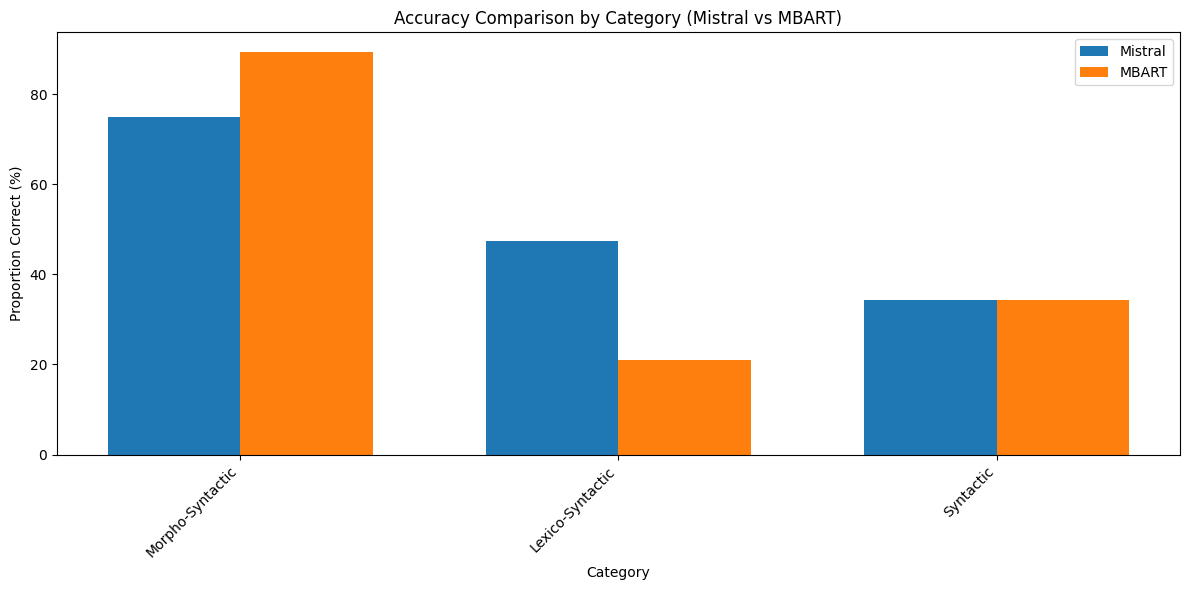

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(mistral_counts, mbart_counts):
    categories = list(mistral_counts.keys())
    total_categories = len(categories)
    bar_width = 0.35
    index = np.arange(total_categories)

    fig, ax = plt.subplots(figsize=(12, 6))
    bar1 = ax.bar(index - bar_width / 2, [(counts['correct'] / counts['total']) * 100 for counts in mistral_counts.values()], bar_width, label='Mistral')
    bar2 = ax.bar(index + bar_width / 2, [(counts['correct'] / counts['total']) * 100 for counts in mbart_counts.values()], bar_width, label='MBART')

    ax.set_xlabel('Category')
    ax.set_ylabel('Proportion Correct (%)')
    ax.set_title('Accuracy Comparison by Category (Mistral vs MBART)')
    ax.set_xticks(index)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_comparison(mistral_counts, mbart_counts)